In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read and prepare the dataset
df = pd.read_csv(
    "../../datasets/housing_price.csv",
    header=0,
    na_values="NA",
    comment="\t",
    sep=",",
    skipinitialspace=True,
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LotArea       1460 non-null   int64
 1   YearBuilt     1460 non-null   int64
 2   TotalBsmtSF   1460 non-null   int64
 3   1stFlrSF      1460 non-null   int64
 4   2ndFlrSF      1460 non-null   int64
 5   FullBath      1460 non-null   int64
 6   BedroomAbvGr  1460 non-null   int64
 7   TotRmsAbvGrd  1460 non-null   int64
 8   GarageArea    1460 non-null   int64
 9   GrLivArea     1460 non-null   int64
 10  MSSubClass    1460 non-null   int64
 11  OverallCond   1460 non-null   int64
 12  SalePrice     1460 non-null   int64
dtypes: int64(13)
memory usage: 148.4 KB


In [4]:
df.head()

,LotArea,YearBuilt,TotalBsmtSF,1stFlrSF,2ndFlrSF,FullBath,BedroomAbvGr,TotRmsAbvGrd,GarageArea,GrLivArea,MSSubClass,OverallCond,SalePrice
0,8450,2003,856,856,854,2,3,8,548,1710,60,5,208500
1,9600,1976,1262,1262,0,2,3,6,460,1262,20,8,181500
2,11250,2001,920,920,866,2,3,6,608,1786,60,5,223500
3,9550,1915,756,961,756,1,3,7,642,1717,70,5,140000
4,14260,2000,1145,1145,1053,2,4,9,836,2198,60,5,250000


- LotArea: Lot size in square feet.
- YearBuilt: Original construction date.
- TotalBsmtSF: Total square feet of basement area.
- 1stFlrSF: First Floor square feet.
- 2ndFlrSF: Second Floor square feet.
- FullBath: Full bathrooms above grade.
- BedroomAbvGr: Number of bedrooms above basement level.
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms).
- GarageArea: Size of garage in square feet.
- GrLivArea: Above grade (ground) living area square feet.
- MSSubClass: The building class.
- OverallCond: Overall condition rating.

In [5]:
# Create the feature input X and target variable Y
X = df.iloc[:,:12]
y = df.iloc[:,12]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Create regression models
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor()

# Define hyperparameter distributions for RandomizedSearchCV
knn_param_dist = {
    "n_neighbors": np.arange(
        1, 21
    ).tolist(),  # Randomly select n_neighbors from 1 to 20
    "weights": ["uniform", "distance"],
}
dt_param_dist = {
    "max_depth": [None]
    + np.arange(1, 31).tolist(),  # Randomly select max_depth from 1 to 30 or None
    "min_samples_split": np.arange(
        2, 11
    ).tolist(),  # Randomly select min_samples_split from 2 to 10
}

# Create RandomizedSearchCV objects for both models
knn_random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=knn_param_dist,
    cv=5,
    scoring="neg_mean_absolute_error",
)
dt_random_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=dt_param_dist,
    cv=5,
    scoring="neg_mean_absolute_error",
)

In [25]:
# Fit the grid searches to the training data
import warnings
warnings.simplefilter("ignore", category=FutureWarning)  # Suppress warnings for cleaner output

knn_random_search.fit(X_train, y_train)
dt_random_search.fit(X_train, y_train)

,estimator,DecisionTreeRegressor()
,param_distributions,"{'max_depth': [None, 1, ...], 'min_samples_split': [2, 3, ...]}"
,n_iter,10
,scoring,'neg_mean_absolute_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [26]:
# Print the best hyperparameters and corresponding accuracy for KNN
print("KNN Best Hyperparameters:", knn_random_search.best_params_)
print("KNN Best Cross-Validation Accuracy:", knn_random_search.best_score_)

KNN Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 7}
KNN Best Cross-Validation Accuracy: -16828.982568904143


In [27]:
# Print the best hyperparameters and corresponding accuracy for Decision Tree
print("Decision Tree Best Hyperparameters:", dt_random_search.best_params_)
print("Decision Tree Best Cross-Validation Accuracy:", dt_random_search.best_score_)

Decision Tree Best Hyperparameters: {'min_samples_split': 4, 'max_depth': 6}
Decision Tree Best Cross-Validation Accuracy: -13513.498075272433


In [28]:
# Evaluate the best models on the test set
best_knn = knn_random_search.best_estimator_
best_dt = dt_random_search.best_estimator_

knn_test_accuracy = best_knn.score(X_test, y_test)
dt_test_accuracy = best_dt.score(X_test, y_test)

print("KNN Test Set Accuracy:", knn_test_accuracy)
print("Decision Tree Test Set Accuracy:", dt_test_accuracy)

KNN Test Set Accuracy: 0.8284808830865262
Decision Tree Test Set Accuracy: 0.8870386083647926


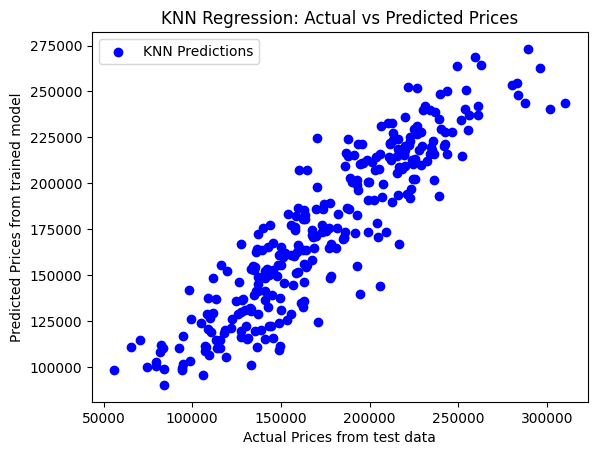

In [29]:
# Scatter plot for original data
y_pred_knn = best_knn.predict(X_test)
plt.scatter(y_test, y_pred_knn, color="blue", label="KNN Predictions")
plt.xlabel("Actual Prices from test data")
plt.ylabel("Predicted Prices from trained model")
plt.title("KNN Regression: Actual vs Predicted Prices")
plt.legend()    # Add legend to the plot for clarity
plt.show()

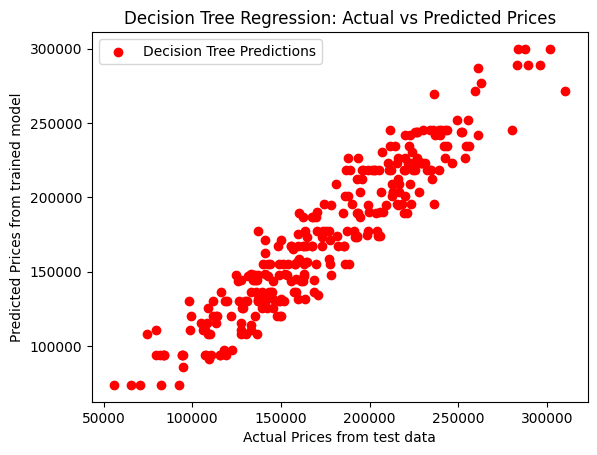

In [30]:
# Scatter plot for original data
y_pred_dt = best_dt.predict(X_test)
plt.scatter(y_test, y_pred_dt, color="red", label="Decision Tree Predictions")
plt.xlabel("Actual Prices from test data")
plt.ylabel("Predicted Prices from trained model")
plt.title("Decision Tree Regression: Actual vs Predicted Prices")
plt.legend()    # Add legend to the plot for clarity
plt.show()